# Coffea-Casa tHq Analysis Tutorial

<h2>Authors</h2>
<b>Notebook by:</b> Mat Adamec (<i>UNL</i>)
<br/>
<b>This tutorial was presented at PyHEP 2020:</b> <a href="https://youtu.be/oPl0t8J36-Q">see it on YouTube</a> (sorry for the minor audio issues!)
<br/>
<br/>
<b>coffea:</b>
<br/>
<a href="https://doi.org/10.5281/zenodo.3899563"><img src="https://zenodo.org/badge/DOI/10.5281/zenodo.3899563.svg" alt="DOI" align="left"></a>
<br/>
    <ul>
        <li>Lindsey Gray, Matteo Cremonesi, Bo Jayatilaka, Oliver Gutsche, Nick Smith, Allison Hall, Kevin Pedro, Maria Acosta <i>(FNAL)</i>; Andrew Melo <i>(Vanderbilt)</i>; Stefano Belforte <i>(INFN)</i>; and others</li>
        <li>In collaboration with IRIS-HEP members: Jim Pivarski <i>(Princeton)</i>, Ben Galewsky <i>(NCSA)</i>, Mark Neubauer <i>(UIUC)</i></li>
        <br/>
    </ul>
<b><a href="https://github.com/CoffeaTeam/coffea-casa">coffea-casa</a>:</b>
    <ul>
        <li>Ken Bloom, Oksana Shadura <i>(UNL)</i>; Garhan Attebury, Carl Lundstedt, Derek Weitzel <i>(UNL-HCC)</i>; Mátyás Selmeci <i>(UWM)</i>; Brian Bockelman <i>(Morgridge Institute)</i></li>
    </ul>
<hr />
<h2>Introduction</h2>
<p>This tutorial is intended to be a walkthrough of the foundations of an analysis implemented in Coffea (specifically, single top-Higgs production, <a href="https://doi.org/10.1103/PhysRevD.99.092005">https://doi.org/10.1103/PhysRevD.99.092005</a>). We will go through data selection using a columnar representation, go over some edge cases to that representation, and plot some relevant data. At the end, we will wrap everything together and demonstrate how Coffea can be easily deployed for scaling an analysis up. This is also a prime opportunity to show off a prototype analysis facility being developed by the coffea-casa team, which was also presented at PyHEP 2020 by Oksana Shadura ("<a href="https://www.youtube.com/watch?v=CDIFd1gDbSc">YouTube: A prototype U.S. CMS analysis facility</a>").</p>


<h2>Foundations</h2>
<p>For the purposes of this tutorial, we will load in a sample file used in the analysis, as well as NanoEvents from the Coffea package. A <a href="https://coffeateam.github.io/coffea/notebooks/nanoevents.html">NanoEvents tutorial</a> is available which gives a detailed description, but I will give a quick exploration of how it can be used to access data.</p>

In [1]:
import numpy as np
import awkward as ak
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import time

file = 'root://xcache//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/38E83594-51BD-7D46-B96D-620DD60078A7.root'
events = NanoEventsFactory.from_root(file, entry_stop=100000).events()

/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FatJet_genJetAK8Idx => GenJetAK8
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for FsrPhoton_muonIdx => Muon
  warnings.warn(
/opt/conda/lib/python3.8/site-packages/coffea/nanoevents/schemas/nanoaod.py:193: RuntimeWarning: Missing cross-reference index for Muon_fsrPhotonIdx => FsrPhoton
  warnings.warn(


<p>NanoEvents lazily reads <code>file</code> into a jagged array structure (specifically, an <a href="https://github.com/scikit-hep/awkward-array">awkward array</a>), <code>events</code>. We can poke around <code>events</code> by looking at the <code>.fields</code> attribute, which tells us all of the possible fields we can access.</p>

In [2]:
print(events)
print('\n')
print(events.fields)

[<event 1:351:70006>, <event 1:351:70008>, ... <event 1:3340:167977>]


['SoftActivityJetNjets10', 'genTtbarId', 'LHEPdfWeight', 'Pileup', 'PuppiMET', 'HLTriggerFinalPath', 'FatJet', 'RawMET', 'LHEReweightingWeight', 'SubJet', 'TrigObj', 'SoftActivityJetHT2', 'PSWeight', 'Electron', 'HLTriggerFirstPath', 'LHE', 'LHEPart', 'SoftActivityJetNjets2', 'SoftActivityJetNjets5', 'btagWeight', 'fixedGridRhoFastjetCentralChargedPileUp', 'TkMET', 'IsoTrack', 'Jet', 'GenVisTau', 'Photon', 'SoftActivityJet', 'SoftActivityJetHT10', 'luminosityBlock', 'HTXS', 'GenMET', 'L1', 'SoftActivityJetHT5', 'GenDressedLepton', 'Tau', 'event', 'ChsMET', 'Generator', 'Muon', 'fixedGridRhoFastjetCentral', 'L1PreFiringWeight', 'fixedGridRhoFastjetCentralCalo', 'MET', 'CorrT1METJet', 'PV', 'fixedGridRhoFastjetAll', 'SoftActivityJetHT', 'HLT', 'LHEWeight', 'Flag', 'fixedGridRhoFastjetCentralNeutral', 'OtherPV', 'CaloMET', 'GenJet', 'run', 'LHEScaleWeight', 'genWeight', 'SV', 'GenPart', 'SubGenJetAK8', 'GenJetAK8', 'L

<p>These fields can be accessed as attributes of the event array. Awkward1 functions can be executed to see additional information. For example, with <code>Muon</code>, we might want to see the size:</p>

In [3]:
print(events.Muon)
print(ak.num(events.Muon, axis=0))
print(ak.sum(ak.num(events.Muon, axis=1)))

[[Muon, Muon], [], [Muon], [], [], ... [Muon, Muon, Muon, Muon], [Muon], [Muon]]
100000
100919


<p>A note about structure: notice that <code>events.Muon</code> is jagged; it is an array of subarrays, which have arbitrary length (they can even be empty)! The only thing that's necessary is that each event has one subarray. As we can see above, in our example some subarrays have one muon, some have two, some have none, some even have four; the total, however, is 100919 muons, spread across 100000 subarrays.</p>
    
<p>In Awkward, <code>ak.num</code> is the standard way to query size. Specifying axis=0 gives you the number of subarrays, while specifying axis=1 gives you an array with the sizes of each subarray, which you can then sum to get the number of muons. If there was further depth to our jaggedness, we might go to axis=2, and so on. Always, 0 is the "least-deep" axis and the maximum axis is the "most-deep."</p>

<p>The <code>Muon</code> array also has further depth to it (most event fields do!) We can look at its fields just as we did with the events array, and we can access any of them as an attribute of <code>events.Muon</code>. As an example, pt:

In [4]:
print(events.Muon.fields)
print('\n')
print(events.Muon.pt)

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'pfRelIso04_all', 'phi', 'pt', 'ptErr', 'segmentComp', 'sip3d', 'tkRelIso', 'tunepRelPt', 'mvaLowPt', 'mvaTTH', 'charge', 'jetIdx', 'nStations', 'nTrackerLayers', 'pdgId', 'tightCharge', 'highPtId', 'inTimeMuon', 'isGlobal', 'isPFcand', 'isTracker', 'looseId', 'mediumId', 'mediumPromptId', 'miniIsoId', 'multiIsoId', 'mvaId', 'pfIsoId', 'softId', 'softMvaId', 'tightId', 'tkIsoId', 'triggerIdLoose', 'genPartIdx', 'genPartFlav', 'cleanmask', 'genPartIdxG', 'jetIdxG']


[[48.4, 32.7], [], [61.2], [], [], ... [49.6, 24.6, 11.8, 3.96], [3.95], [18]]


It's important that you feel comfortable accessing data within the <code>events</code> array as a basis for the rest of this tutorial. Please, take a moment and play around with it!

Now, we can access data, but how do we manipulate it? Possibly the most critical component of columnar analysis is the concept of masking. A mask is an array of booleans, which another array can be masked by, thus accepting or rejecting elements of that array based on whether the corresponding mask element is <code>True</code> or <code>False</code>. A basic example below:

In [5]:
data = np.array(['a', 'b', 'd', 'c'])
mask = np.array([True, True, False, True])

data[mask]

array(['a', 'b', 'c'], dtype='<U1')

<p>We can generate a mask by executing a conditional statement involving any of our awkward arrays. Let's say we want to select muons whose pt > 40:</p>

In [6]:
muons = events.Muon

print('Unmasked data:')
print(muons.pt)

print('\nMask of data:')
print(muons.pt > 40)

print('\nMasked data:')
print(muons.pt[muons.pt > 40])

Unmasked data:
[[48.4, 32.7], [], [61.2], [], [], ... [49.6, 24.6, 11.8, 3.96], [3.95], [18]]

Mask of data:
[[True, False], [], [True], [], ... [True, False, False, False], [False], [False]]

Masked data:
[[48.4], [], [61.2], [], [], [77.5], [], ... [50.6], [], [], [], [49.6], [], []]


We will employ masking in our analysis to reject leptons and events which do not meet the cuts that we desire.

<h2>Lepton Selection</h2>
<p>Let's now begin with some lepton selectionn, which lends itself towards a simple columnar implementation. We will begin with muons, which have relatively straight-forward cuts, and show off some more complexity with electrons. All tables of cuts are taken from the single top-Higgs analysis mentioned above.<p>

<h3><center>Muon Selection</center></h3>

<center><img src="../../docs/muon_selection_tabular.png"/></center>

How would we make these cuts with our columnar tools? An easy three-step plan: 
<ol>
    <li>generate a mask for each condition</li>
    <li>combine them together into a single mask</li>
    <li>mask the muon array with the final mask</li>
</ol>

In practice, we can skip the second step by stringing our conditionals together with &'s. A quick warning: for masks in Coffea, '&' should always be used over 'and,' as the latter is considered ambiguous. This is an underlying quirk of numpy.

<p>The only intermediate step is figuring out which fields you need and how they are structured; I've left in an extra cell if you want to poke at any specific ones.</p>

In [7]:
loose_muons = muons[(np.abs(muons.eta) < 2.4) &
                    (muons.pt > 5) &
                    (np.abs(muons.dxy) < 0.05) &
                    (np.abs(muons.dz) < 0.1) &
                    (muons.sip3d < 8) &
                    (muons.miniPFRelIso_all < 0.4) &
                    (muons.looseId)]
                    # Note that no other cuts are necessary for loose muons!

# To construct the tight selection, we may as well make use of the loose cut, since they overlap.
tight_muons = loose_muons[(loose_muons.pt > 15) &
                         (loose_muons.mediumId) &
                         (loose_muons.tightCharge > 1) &
                         (loose_muons.mvaTTH > 0.9)]

In [8]:
print(muons.fields)
print('\n')
print(muons.mediumId)

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'pfRelIso04_all', 'phi', 'pt', 'ptErr', 'segmentComp', 'sip3d', 'tkRelIso', 'tunepRelPt', 'mvaLowPt', 'mvaTTH', 'charge', 'jetIdx', 'nStations', 'nTrackerLayers', 'pdgId', 'tightCharge', 'highPtId', 'inTimeMuon', 'isGlobal', 'isPFcand', 'isTracker', 'looseId', 'mediumId', 'mediumPromptId', 'miniIsoId', 'multiIsoId', 'mvaId', 'pfIsoId', 'softId', 'softMvaId', 'tightId', 'tkIsoId', 'triggerIdLoose', 'genPartIdx', 'genPartFlav', 'cleanmask', 'genPartIdxG', 'jetIdxG']


[[True, True], [], [True], [], [], ... [True, False, False, True], [True], [True]]


<p>Let's do the same thing for electrons, which are slightly complicated because some of the cuts fall into a set of two ranges: 0 < |$\eta$| < 1.479 and 1.479 < |$\eta$| < 2.5. These are listed respectively in parentheses: (<i>range 1, range 2</i>).</p>

<h3><center>Electron Selection</center></h3>

<center><img src="../../docs/electron_selection_tabular.png"/></center>

A cell has been provided, again, for field-prodding purposes.

In [9]:
electrons = events.Electron

# This ends up getting referenced a lot. Let's not generate it every time!
abs_eta = np.abs(electrons.eta)

loose_electrons = electrons[(abs_eta < 2.5) &
                           (electrons.pt > 7) &
                           (np.abs(electrons.dxy) < 0.05) &
                           (np.abs(electrons.dz) < 0.1) &
                           (electrons.miniPFRelIso_all < 0.4) &
                           (electrons.lostHits < 2) &
                           # The scary one, the only one with two ranges in loose selection. 
                           (((electrons.mvaFall17V2noIso > 0) & (abs_eta < 1.479)) |
                            ((electrons.mvaFall17V2noIso > 0.7) & (abs_eta > 1.479) & (abs_eta < 2.5)))]

# Again, all tight leptons pass the loose cut, so we may as well cut down on passing the same cuts twice.
# But we'll have to redefine abs_eta again!
abs_eta = np.abs(loose_electrons.eta)

tight_electrons = loose_electrons[(loose_electrons.pt > 15) &
                                 (loose_electrons.lostHits == 0) &
                                 (loose_electrons.tightCharge > 1) &
                                 (loose_electrons.convVeto) &
                                 (loose_electrons.mvaTTH > 0.90) &
                                 # Two ranges for sigma_ieie.
                                 (((abs_eta < 1.479) & (loose_electrons.sieie < 0.011)) | 
                                 ((abs_eta < 2.5) & (abs_eta > 1.479) & (loose_electrons.sieie < 0.03))) &
                                 # Two ranges for H/E
                                 (((abs_eta < 1.479) & (loose_electrons.hoe < 0.1)) | 
                                 ((abs_eta < 2.5) & (abs_eta > 1.479) & (loose_electrons.hoe < 0.07))) &
                                 # Two ranges for 1/E - 1/p
                                 (((abs_eta < 1.479) & (loose_electrons.eInvMinusPInv < 0.01) & (loose_electrons.eInvMinusPInv > -0.05)) |
                                 ((abs_eta < 2.5) & (abs_eta > 1.479) & (loose_electrons.eInvMinusPInv < 0.005) & (loose_electrons.eInvMinusPInv > -0.05)))]

In [10]:
print(events.Electron.fields)
print('\n')
print(events.Electron.lostHits)

['deltaEtaSC', 'dr03EcalRecHitSumEt', 'dr03HcalDepth1TowerSumEt', 'dr03TkSumPt', 'dr03TkSumPtHEEP', 'dxy', 'dxyErr', 'dz', 'dzErr', 'eCorr', 'eInvMinusPInv', 'energyErr', 'eta', 'hoe', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'mvaFall17V1Iso', 'mvaFall17V1noIso', 'mvaFall17V2Iso', 'mvaFall17V2noIso', 'mvaSpring16GP', 'mvaSpring16HZZ', 'pfRelIso03_all', 'pfRelIso03_chg', 'phi', 'pt', 'r9', 'sieie', 'sip3d', 'mvaTTH', 'charge', 'cutBased', 'cutBased_Fall17_V1', 'cutBased_HLTPreSel', 'cutBased_Spring15', 'cutBased_Sum16', 'jetIdx', 'pdgId', 'photonIdx', 'tightCharge', 'vidNestedWPBitmap', 'vidNestedWPBitmapSpring15', 'vidNestedWPBitmapSum16', 'convVeto', 'cutBased_HEEP', 'isPFcand', 'lostHits', 'mvaFall17V1Iso_WP80', 'mvaFall17V1Iso_WP90', 'mvaFall17V1Iso_WPL', 'mvaFall17V1noIso_WP80', 'mvaFall17V1noIso_WP90', 'mvaFall17V1noIso_WPL', 'mvaFall17V2Iso_WP80', 'mvaFall17V2Iso_WP90', 'mvaFall17V2Iso_WPL', 'mvaFall17V2noIso_WP80', 'mvaFall17V2noIso_WP90

<h2>Event Selections</h2>
<p>Okay, now that we've selected some good leptons, let's follow the event selection as prescribed:</p>

<center><img src="../../docs/event_selection_tabular.png"/></center>

In order to simplify all of these cuts, we're just going to go step-by-step in generating individual masks for each condition, and then we'll combine them all at the end. We begin with the jet cuts. Note that we're only interested in having <b>at least one</b> jet passing or failing the respective working points, so while any conditionals we make are per-jet, what we actually want is a per-event mask. We can sum the <code>True</code>s in each subarray and make sure there is at least one, since they are equivalent to 1 (and <code>False</code> is 0).

In [11]:
loose_wp = 0.5425
medium_wp = 0.8484
        
jets = events.Jet

jetMask_medium = ((np.abs(jets.eta) < 2.4) & (jets.pt > 25) &
                  (jets.btagCSVV2 > medium_wp))
print('Jet Level (all jets)')
print(jetMask_medium)
jetMask_medium = ak.sum(jetMask_medium, axis=1) >= 1
print('\nEvent Level (at least one jet)')
print(jetMask_medium)

jetMask_loose = ak.sum(((((np.abs(jets.eta) < 2.4) & (jets.pt > 25)) | ((jets.pt > 40) & (np.abs(jets.eta) > 2.4))) &
                 (jets.btagCSVV2 <= loose_wp)), axis=1) >= 1

Jet Level (all jets)
[[False, False, True, False, False, False, ... False, False, False, False, False]]

Event Level (at least one jet)
[True, True, True, True, True, True, True, ... False, True, True, True, True, True]


<p>Okay, the next challenge we come to is making sure there are "no loose leptons with $m_{ll} < 12 GeV$." A problem immediately arises: how do we work with all pairs of <b>leptons</b>? We have an array of muons, we have an array of electrons, but we don't have a singular <code>Lepton</code> object. A columnar solution would be to construct such an object, while adding in an additional index variable to identify muons and electrons apart from each other, so that they remain distinct.</p>

<p>As of Awkward1, building such an object is possible (for versions of coffea < 0.7, you'll have to find a workaround)! We first need to add a flavor field (which is labeled 0 for muons, 1 for electrons), and then concatenate the two lepton arrays:</p>

In [12]:
loose_muons = ak.with_field(loose_muons, 0, 'flavor')
loose_electrons = ak.with_field(loose_electrons, 1, 'flavor')
# Note the addition of ak.with_name. This just preserves the use of some functions that Muon and Electron had (e.g., delta_r())
loose_leptons = ak.with_name(ak.concatenate([loose_muons, loose_electrons], axis=1), 'PtEtaPhiMCandidate')

Let's take a look at this in practice. Below, we can see our muon and electron pts, and then the pts of our new leptons array. We can still recover whether an object is a <code>Muon</code> or <code>Electron</code> because we've added our flavor field.

In [13]:
print('Muons:')
print(loose_muons.pt)
print('\nElectrons:')
print(loose_electrons.pt)
print('\nLeptons:')
print(loose_leptons.pt)
print('\nLepton Types:')
print(loose_leptons.flavor)

Muons:
[[32.7], [], [61.2], [], [], [77.5], [], ... [50.6], [], [], [15.9], [], [], []]

Electrons:
[[], [84.5, 27.3], [89.7], [37.1], [], [], ... 94.4], [], [95.8], [], [], [7.58], []]

Leptons:
[[32.7], [84.5, 27.3], [61.2, 89.7], [37.1], ... [95.8], [15.9], [], [7.58], []]

Lepton Types:
[[0], [1, 1], [0, 1], [1], [], [0], [], ... 1], [0, 1], [], [1], [0], [], [1], []]


<p>Now, let's return to our selection! Recall that our goal is to have "no loose leptons with $m_{ll} < 12 GeV$." Okay; all we need is to generate all pairs within our <code>loose_leptons</code> array and ensure they meet our mass requirement.</p>

<p>Luckily, Awkward1 also comes with combinatorics tools that help us with the "get all pairs" portion. In particular, <code>ak.combinations(loose_leptons, 2)</code> will generate all possible pairs of leptons in each event. We can add an optional <code>fields</code> attribute so that we can retrieve each part of the pairs (for, say, adding them together).</p>
    
<p>Below, we print the pt of each subcomponent of this process as a demonstration. Note some limitations: <code>loose_pairs</code> does not have a pt because it is a tuple, so to see the pt of both of our pairs I had to generate a separate combination of the <code>loose_leptons</code> pts.</p>

In [14]:
loose_pairs = ak.combinations(loose_leptons, 2, fields=['i0', 'i1'])
print('Leptons:')
print(loose_leptons.pt)
print('\nLepton Pairs:')
print(ak.combinations(loose_leptons.pt, 2))
print('\nFirst of Pair:')
print(loose_pairs['i0'].pt)
print('\nSecond of Pair:')
print(loose_pairs['i1'].pt)

Leptons:
[[32.7], [84.5, 27.3], [61.2, 89.7], [37.1], ... [95.8], [15.9], [], [7.58], []]

Lepton Pairs:
[[], [(84.5, 27.3)], [(61.2, 89.7)], [], ... 50.6, 94.4)], [], [], [], [], [], []]

First of Pair:
[[], [84.5], [61.2], [], [], [], [], [], ... [], [50.6], [], [], [], [], [], []]

Second of Pair:
[[], [27.3], [89.7], [], [], [], [], [], ... [], [94.4], [], [], [], [], [], []]


In [15]:
loose_pairs_mass = (loose_pairs.i0 + loose_pairs.i1).mass
looseMask = (ak.all(loose_pairs_mass >= 12, axis=1) & ak.num(loose_pairs_mass) > 0)

<p>We will now implement the rest of these, making use of our stacked array object. As a reminder, those cuts are:</p>

<center><img src="../../docs/event_selection_tabular.png"/></center>

In [16]:
# Dilepton selection.
tight_muons = ak.with_field(tight_muons, 0, 'flavor')
tight_electrons = ak.with_field(tight_electrons, 1, 'flavor')
tight_leptons = ak.with_name(ak.concatenate([tight_muons, tight_electrons], axis=1), 'PtEtaPhiMCandidate')
tight_pairs = ak.combinations(tight_leptons, 2, fields=['i0', 'i1'])

# We want exactly one same-sign pair.
dileptonMask = ak.any(((ak.num(tight_pairs) == 1) & (tight_pairs['i0'].charge == tight_pairs['i1'].charge)), axis=1)

# We want at least one lepton to have pt > 25. They have pt > 15 through the lepton selection.
dileptonMask = dileptonMask & ak.any(((tight_pairs['i0'].pt > 25) | (tight_pairs['i1'].pt > 25)), axis=1)

# Okay, now we need to identify ee pairs, and check that their separation from the Z mass is sufficient.
# Our flavor tracker helps us with this. If we add the flavor of a pair, then since e = 1, mu = 0, 2 indicates ee.
tight_types = (tight_pairs['i0'].flavor + tight_pairs['i1'].flavor)
dileptonMask = dileptonMask & ak.any(((tight_types < 2) | (np.abs((tight_pairs['i0'] + tight_pairs['i1']).mass - 91.18) > 10)), axis=1)
    
    
# Trilepton selection.
tight_triples = ak.combinations(tight_leptons, 3, fields=['i0', 'i1', 'i2'])

# We want exactly three leptons in each event, or one triplet.
trileptonMask = (ak.num(tight_triples) == 1)

# Again, we want at least one lepton in the triplet to have pt > 25.
trileptonMask = trileptonMask & ak.any((tight_triples['i0'].pt > 25) | (tight_triples['i1'].pt > 25) | (tight_triples['i2'].pt > 25), axis=1)

# Then we want to discard OSSF pairs that are close to the Z mass. We don't need our stacked array for this.
tight_muon_pairs = ak.combinations(tight_muons, 2, fields=['i0', 'i1'])
tight_electron_pairs = ak.combinations(tight_electrons, 2, fields=['i0', 'i1'])

# Takes a pair, tells you if it is an OSSF with |m_ll - m_z| < 15. Reject these events.
def ossf_zmass_check(dileptons):
    return ak.any((dileptons['i0'].charge != dileptons['i1'].charge) & 
            (np.abs(91.18 - (dileptons['i0'] + dileptons['i1']).mass) < 15.), axis=1)

trileptonMask = trileptonMask & (~ossf_zmass_check(tight_muon_pairs)) & (~ossf_zmass_check(tight_electron_pairs))

And that gives us masks for all of the conditions we need. We can now go back to our friendly arrays, put all of our masks together, and apply them to our leptons with ease, getting a dilepton and a three-lepton array for each lepton.

In [17]:
dilepton_event = (looseMask) & (dileptonMask) & (jetMask_medium) & (jetMask_loose)
trilepton_event = (looseMask) & (trileptonMask) & (jetMask_medium) & (jetMask_loose)

tight_ll_electrons = tight_electrons[dilepton_event]
tight_lll_electrons = tight_electrons[trilepton_event]
tight_ll_muons = tight_muons[dilepton_event]
tight_lll_muons = tight_muons[trilepton_event]

From here, we can break our results naturally into different channels in a columnar fashion. For example, mumu events are simply those where <code>tight_ll_muons.counts == 2</code>, as the dileptonMask guarantees events with 2 leptons, and 2 muons thus implies 0 electrons.

In [18]:
mumu_channel = tight_ll_muons[ak.num(tight_ll_muons) == 2]
ee_channel = tight_ll_electrons[ak.num(tight_ll_electrons) == 2]

<h2>Plotting</h2>
<p>On to some visuals! Coffea analyses often use the [hist](hist.readthedocs.io/en/latest/) package, which will be comfortable and familiar to use if you've ever touched Matplotlib. We can use this library, again with some minor columnar manipulations, to plot some parameters of interest. Let's stick to the mumu and ee channels for this, since they're already defined above.
<p>Let's try something simple: a plot of the pt of the 2nd-highest-pt lepton in each event. Because awkward arrays are naturally sorted from highest to lowest pt, this'll just involve slicing an array to get the second muon in each event.</p>

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fac8b55fb50>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fac8a20dee0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

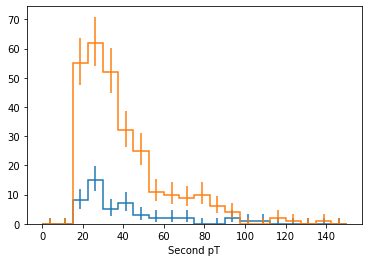

In [20]:
import hist

# For all event pts (:), get second index (1). Also, removed jagged structure to get flat array.
mumu_pt2 = mumu_channel.pt[:, 1]
ee_pt2 = ee_channel.pt[:, 1]

second_pt = hist.Hist(hist.axis.StrCategory(name='channel', label='Channel', categories=['ee', 'mumu']), 
                      hist.axis.Regular(name='pt2', label='Second pT', bins=20, start= 0, stop=150))

second_pt.fill(channel='mumu', pt2=mumu_pt2)
second_pt.fill(channel='ee', pt2=ee_pt2)

second_pt.plot1d()

<p>How about something with a little more topology? Let's plot "$\Delta \eta$ between the max-$\eta$ light jet and the max-pt bjet." In our case, a light jet will be defined as one that fails <code>loose_wp</code> and a bjet will be one that passes <code>medium_wp</code>. For simplicity, we will stay strictly in the mumu channel.

In [21]:
mumu_jets = jets[dilepton_event & (ak.num(tight_muons) == 2)]

light_jets = mumu_jets[mumu_jets.btagCSVV2 <= loose_wp]
bjets = mumu_jets[mumu_jets.btagCSVV2 > medium_wp]

Now, this cut is simplified slightly by the fact that we only desire one of each jet type in an event. We can thus do a simple array selection to get our max-$\eta$ light jet and our max-pt bjet, then do a <code>.cross()</code> between them to generate the pairs (and filter out empty events, though our event selection should disallow this). A <code>.cross()</code> is like a <code>.choose()</code>, but it generates pairs across arrays, rather than within one.

In [22]:
# argmax() returns the index of the maximum-valued element. Just another way to get max for an unordered array.
max_light_jets = light_jets[ak.local_index(light_jets, axis=1) == ak.argmax(light_jets.eta, axis=1)]
max_bjets = bjets[ak.local_index(bjets, axis=1) == ak.argmax(bjets.pt, axis=1)] 

cross_jets = ak.cartesian({'i0': max_bjets, 'i1': max_light_jets})
print('Max-pt bjets:')
print(max_bjets)
print('\nMax-Eta Light Jets:')
print(max_light_jets)
print('\nCrossed:')
print(cross_jets)

Max-pt bjets:
[[Jet], [Jet], [Jet], [Jet], [Jet], [Jet, ... [Jet], [Jet], [Jet], [Jet], [Jet]]

Max-Eta Light Jets:
[[Jet], [Jet], [Jet], [Jet], [Jet], [Jet, ... [Jet], [Jet], [Jet], [Jet], [Jet]]

Crossed:
[[{i0: Jet, i1: Jet}], [{i0: Jet, i1: Jet}], ... i1: Jet}], [{i0: Jet, i1: Jet}]]


And now all we have to do is find the difference in $\eta$ between the values of the pair. The respective pair-wise elements can once again be accessed by <code>.i0</code> and <code>.i1</code>. We take their difference (which is taking the difference of their Lorentz vector) and then ask for $\eta$.

/opt/conda/lib/python3.8/site-packages/mplhep/error_estimation.py:38: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  warnings.warn(


[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fac90168af0>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>),
 StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7fac8a931250>, errorbar=<ErrorbarContainer object of 3 artists>, legend_artist=<ErrorbarContainer object of 3 artists>)]

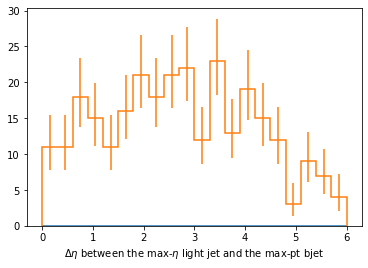

In [23]:
# For all event pts (:), get second index (1). Also, removed jagged structure to get flat array.
mumu_fwdJet_leadbJet = np.abs(cross_jets['i0'].eta - cross_jets['i1'].eta)

mumu_etadiff = hist.Hist(hist.axis.StrCategory(name='channel', label='Channel', categories=['ee', 'mumu']),
                      hist.axis.Regular(name='etadiff', label=r'$\Delta \eta$ between the max-$\eta$ light jet and the max-pt bjet', bins=20, start=0, stop=6))

mumu_etadiff.fill(channel='mumu', etadiff=ak.flatten(mumu_fwdJet_leadbJet))
mumu_etadiff.plot1d()

<h2>Demo</h2>
<p>Alright, we've seen a lot of neat columnar tools, but it doesn't end there! Coffea also makes scale-out easy. All we have to do is bundle up our work in the <code>process.ProcessorABC</code> class, and we can feed in however many files we desire (which is, probably, more than 1) with ease. This class also features several executors which allow deployment on Dask, Spark, and Parsl, as well as your local machine. 

<p>To end this tutorial, we will diverge from this notebook a little bit, as I will demonstrate a run of the analysis on a Dask cluster; specifically, the coffea-casa analysis facility mentioned earlier. If you want to look at, use as a reference, or play with my analysis later, you can run <a href="./analysis-local.ipynb">the analysis file that I've provided</a>, which uses the futures_executor to execute locally. You will, however, need a CMS certificate to be able to access its datasets. Failure to do so will result in the oh-so-familiar <code>OSError: [FATAL] Invalid address</code>.

<h2>Acknowledgements</h2>
<p>These projects are supported by National Science Foundation grants ACI-1450323 (through DIANA-HEP), OAC-1836650 (through IRIS-HEP), and PHY-1624356 (through U.S. CMS).</p>